In [1]:
%cd ..

C:\Users\bloic\Desktop\Promutuel_technique


In [2]:
from os.path import join
from config import *
from functions import *

import re
from collections import OrderedDict

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# Deep Learning

Dans ce notebook, nous allons utiliser l'apprentissage profond afin de fixer/prédire le prix d'une location en fonction des données que nous possédons sur Airbnb.

*Rappel* : Nous avons vu dans la section *analyse/feature_selection* que les modèles linéaires ne performent pas bien sur notre jeu de données.

## Prétraitement des données

On reprend exactement la même portion de code que pour le *notebook* *analyse/feature_selection*.  
Nous pourrions factoriser le code dans une fonction mais ce ne serait pas optimal puisqu'il est possible que nous ayons des modifications à faire à la volée.

In [3]:
# On se focalise sur le listing
df_listings = pd.read_csv(join(DATA_DIR, 'listings_data.csv'))

regex = re.compile('[$,]')
df_listings['price'] = df_listings['price'].apply(lambda x: regex.sub('', x)).astype(np.float)

# Sélection de features intéressantes
num_cols = ~(df_listings.dtypes == 'object')
num_cols = num_cols[num_cols].index.to_list()
features = []
# On enlève les IDs
for col in num_cols:
    if 'id' not in col:
        features.append(col)
df_listings[features].dtypes

features.remove('license')
features.remove('calendar_updated')
features.remove('bathrooms')
features.remove('neighbourhood_group_cleansed')
# Les features non informels
features.remove('latitude')
features.remove('longitude')

# 0 chambres quand non renseigné
df_listings['bedrooms'].fillna(0., inplace=True)
# Au moins 1 lit
df_listings['beds'].fillna(1., inplace=True)
# Les scores par catégories --> (a+b) / 2 pour ne pas "pénaliser" le manque de note. Note comprise dans l’intervalle [a, b]
df_listings['review_scores_rating'].fillna(50., inplace=True)
df_listings['review_scores_cleanliness'].fillna(5., inplace=True)
df_listings['review_scores_checkin'].fillna(5., inplace=True)
df_listings['review_scores_communication'].fillna(5., inplace=True)
df_listings['review_scores_location'].fillna(5., inplace=True)
df_listings['review_scores_value'].fillna(5., inplace=True)

# Pour ne pas perturber et ajouter de l’information, pour ces valeurs on attribue à 0 l’accuracy
df_listings['review_scores_accuracy'].fillna(0., inplace=True)
df_listings['reviews_per_month'].fillna(0., inplace=True) # Pareil pour le nombre de reviews

indexes = df_listings[df_listings['price'] > 1000].index
df_listings.drop(indexes, inplace=True)

# Le prix n’est pas une feature
features.remove('price')

minmax = MinMaxScaler()

X_data = minmax.fit_transform(df_listings[features].to_numpy())
y_data = minmax.fit_transform(df_listings['price'].to_numpy().reshape(-1, 1)).ravel()

## Split des données train/test/valid

Nous n’avons pas à nous en faire, l’ordonnancement est conservé pendant la conversion Pandas $\rightarrow$ Numpy.

In [4]:
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_data, y_data, train_ratio=0.8, valid_ratio=0.1)

# Conversion en tenseurs (important)
X_train, X_valid, X_test = convert_tensor(X_train, X_valid, X_test, dtype=torch.float32)
y_train, y_valid, y_test = convert_tensor(y_train, y_valid, y_test, dtype=torch.float32)

train_dataset = AirbnbDataset(X_train, y_train)
valid_dataset = AirbnbDataset(X_valid, y_valid)
test_dataset = AirbnbDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Nous séléctionnons une *batch size* de 8 afin d'avoir suffisamment de mises à jour des poids, puisque rappelons le, nous ne possédons que 2316 données.

## Modèles

Commençons par un simple réseau de neurones à plusieurs couches.

### Multi Layer Perceptron

In [5]:
class MLP(nn.Module):
    def __init__(self, in_features=32, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=32)
        self.regress = nn.Linear(in_features=32, out_features=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        y = self.regress(x)
        return y

In [6]:
# test pour s’assurer que le flux de données passe bien au travers du réseau
model = MLP()
X_data = torch.FloatTensor(X_data)
with torch.no_grad():
    res = model(X_data[:10])
print(res.shape)

torch.Size([10, 1])


Le modèle est prêt pour l’apprentissage !

#### Overfitting

Nous cherchons à overfitter sur un des jeu de données, par exemple celui de test ou de valid puisqu'ils sont plus petits que le train.  
Faire overfitter le modèle va nous indiquer si le modèle est pertinent et qu'il a les capacités d'apprendre de notre jeu de données.

In [7]:
model = MLP()

loss = nn.MSELoss()

lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr)

hist = train(model, optimizer, loss, train_loader=test_loader, epochs=300, gpu=0)

Epoch : 1 - Train Loss : 3.42e-02
Epoch : 2 - Train Loss : 1.81e-02
Epoch : 3 - Train Loss : 1.19e-02
Epoch : 4 - Train Loss : 9.45e-03
Epoch : 5 - Train Loss : 8.46e-03
Epoch : 6 - Train Loss : 8.06e-03
Epoch : 7 - Train Loss : 7.89e-03
Epoch : 8 - Train Loss : 7.83e-03
Epoch : 9 - Train Loss : 7.80e-03
Epoch : 10 - Train Loss : 7.78e-03
Epoch : 11 - Train Loss : 7.77e-03
Epoch : 12 - Train Loss : 7.76e-03
Epoch : 13 - Train Loss : 7.76e-03
Epoch : 14 - Train Loss : 7.75e-03
Epoch : 15 - Train Loss : 7.74e-03
Epoch : 16 - Train Loss : 7.73e-03
Epoch : 17 - Train Loss : 7.73e-03
Epoch : 18 - Train Loss : 7.72e-03
Epoch : 19 - Train Loss : 7.72e-03
Epoch : 20 - Train Loss : 7.71e-03
Epoch : 21 - Train Loss : 7.71e-03
Epoch : 22 - Train Loss : 7.70e-03
Epoch : 23 - Train Loss : 7.70e-03
Epoch : 24 - Train Loss : 7.69e-03
Epoch : 25 - Train Loss : 7.69e-03
Epoch : 26 - Train Loss : 7.68e-03
Epoch : 27 - Train Loss : 7.68e-03
Epoch : 28 - Train Loss : 7.67e-03
Epoch : 29 - Train Loss : 7.6

Epoch : 237 - Train Loss : 6.75e-03
Epoch : 238 - Train Loss : 6.75e-03
Epoch : 239 - Train Loss : 6.74e-03
Epoch : 240 - Train Loss : 6.74e-03
Epoch : 241 - Train Loss : 6.73e-03
Epoch : 242 - Train Loss : 6.73e-03
Epoch : 243 - Train Loss : 6.73e-03
Epoch : 244 - Train Loss : 6.72e-03
Epoch : 245 - Train Loss : 6.72e-03
Epoch : 246 - Train Loss : 6.71e-03
Epoch : 247 - Train Loss : 6.71e-03
Epoch : 248 - Train Loss : 6.70e-03
Epoch : 249 - Train Loss : 6.70e-03
Epoch : 250 - Train Loss : 6.70e-03
Epoch : 251 - Train Loss : 6.69e-03
Epoch : 252 - Train Loss : 6.69e-03
Epoch : 253 - Train Loss : 6.68e-03
Epoch : 254 - Train Loss : 6.68e-03
Epoch : 255 - Train Loss : 6.67e-03
Epoch : 256 - Train Loss : 6.67e-03
Epoch : 257 - Train Loss : 6.67e-03
Epoch : 258 - Train Loss : 6.66e-03
Epoch : 259 - Train Loss : 6.66e-03
Epoch : 260 - Train Loss : 6.65e-03
Epoch : 261 - Train Loss : 6.65e-03
Epoch : 262 - Train Loss : 6.64e-03
Epoch : 263 - Train Loss : 6.64e-03
Epoch : 264 - Train Loss : 6

#### Petite visualisation de l’entrainement

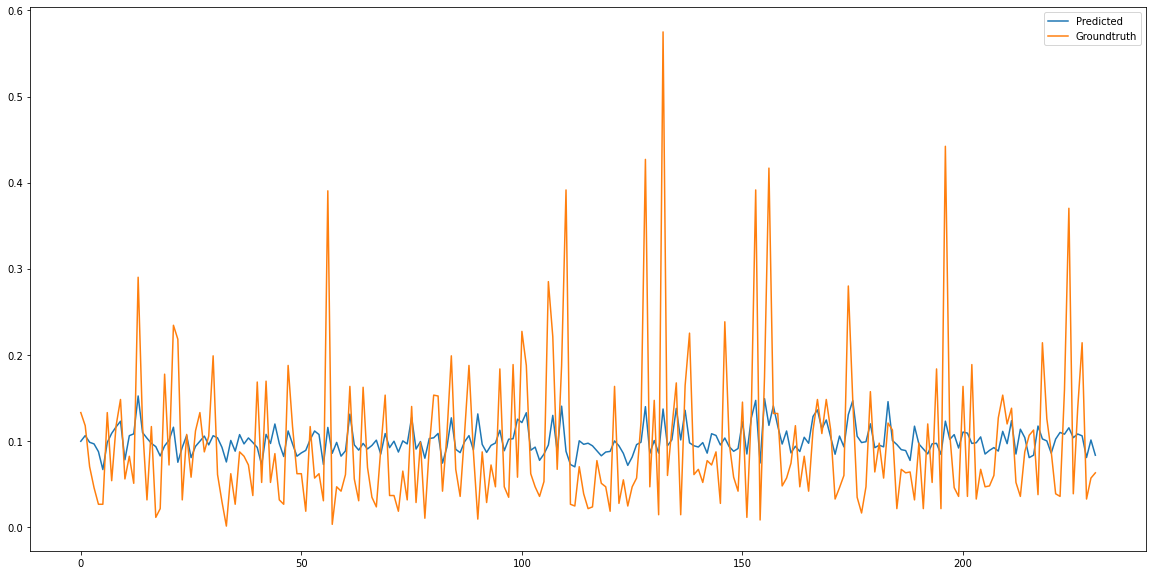

In [8]:
y_pred = predict(model, tensor_data=X_test, gpu=0)

plt.figure(figsize=(20, 10))
plt.plot(y_pred, label='Predicted')
plt.plot(y_test, label='Groundtruth')
plt.legend()
plt.show()

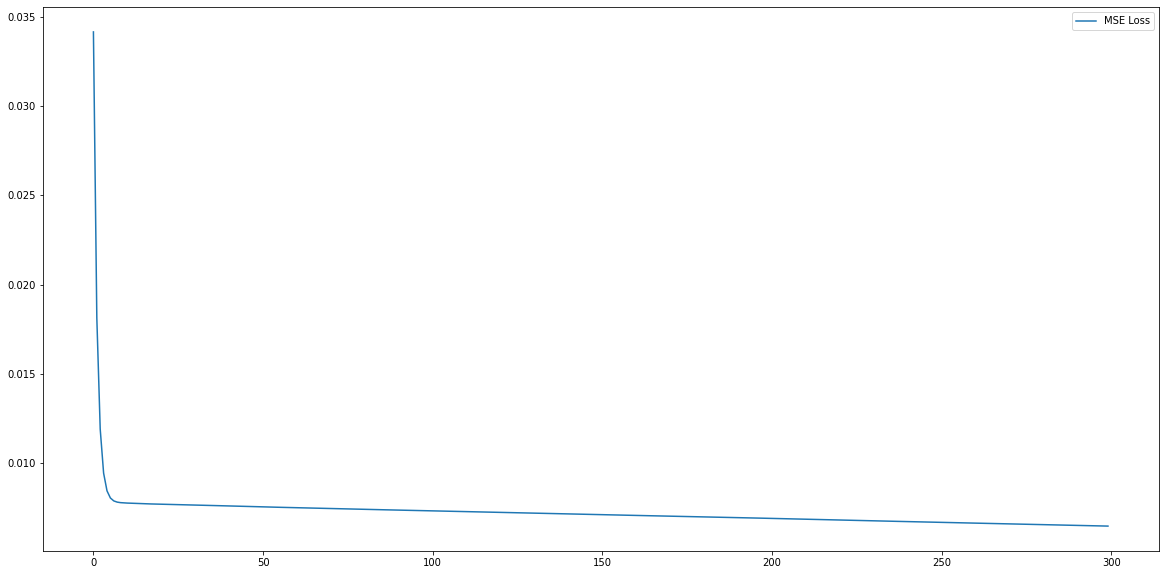

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(hist, label='MSE Loss')
plt.legend()
plt.show()

Nous avons bien réussi à overfitter sur notre set de test. Maintenant entrainons réellement le réseau.

#### Entrainement

In [10]:
model = MLP()

loss = nn.MSELoss()

lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

hist = train(model, optimizer, loss, train_loader=train_loader, valid_loader=valid_loader, epochs=100, scheduler=scheduler, gpu=0)

Epoch : 1 - Train Loss : 1.13e-02 - - Valid Loss : 1.38e-02
Epoch : 2 - Train Loss : 1.08e-02 - - Valid Loss : 1.36e-02
Epoch : 3 - Train Loss : 1.06e-02 - - Valid Loss : 1.34e-02
Epoch : 4 - Train Loss : 1.05e-02 - - Valid Loss : 1.32e-02
Epoch : 5 - Train Loss : 1.03e-02 - - Valid Loss : 1.31e-02
Epoch : 6 - Train Loss : 1.02e-02 - - Valid Loss : 1.29e-02
Epoch : 7 - Train Loss : 1.00e-02 - - Valid Loss : 1.26e-02
Epoch : 8 - Train Loss : 9.81e-03 - - Valid Loss : 1.23e-02
Epoch : 9 - Train Loss : 9.62e-03 - - Valid Loss : 1.21e-02
Epoch : 10 - Train Loss : 9.42e-03 - - Valid Loss : 1.19e-02
Epoch : 11 - Train Loss : 9.23e-03 - - Valid Loss : 1.17e-02
Epoch : 12 - Train Loss : 9.06e-03 - - Valid Loss : 1.15e-02
Epoch : 13 - Train Loss : 8.91e-03 - - Valid Loss : 1.14e-02
Epoch : 14 - Train Loss : 8.78e-03 - - Valid Loss : 1.13e-02
Epoch : 15 - Train Loss : 8.68e-03 - - Valid Loss : 1.13e-02
Epoch : 16 - Train Loss : 8.59e-03 - - Valid Loss : 1.12e-02
Epoch : 17 - Train Loss : 8.52e-0

In [11]:
hist_test = test(model, loss, test_loader=test_loader, gpu=0)

Test batch : 15 / 15

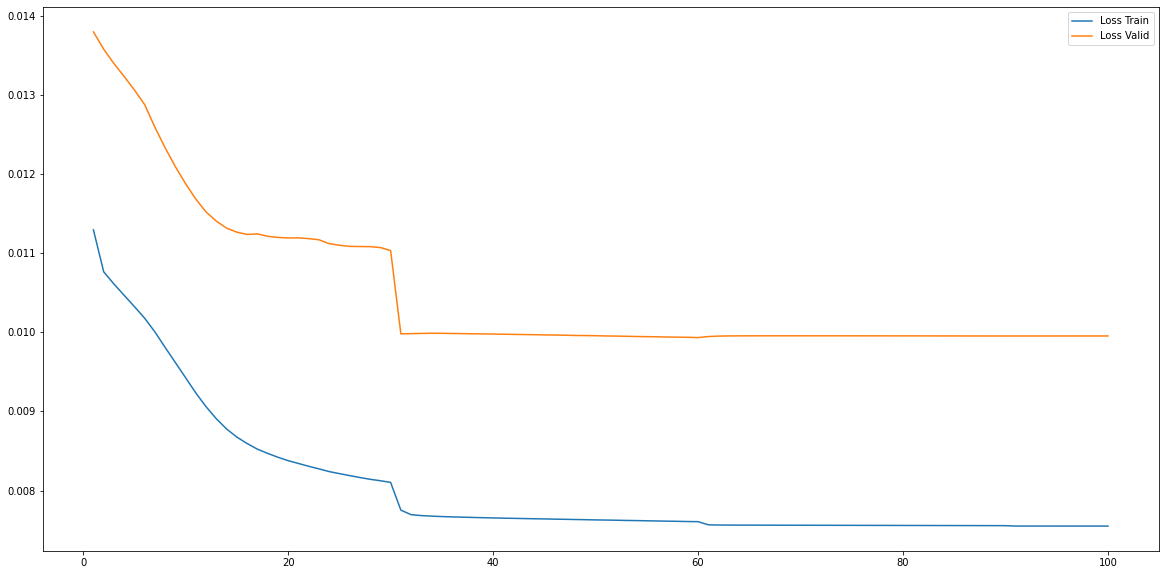

In [12]:
plt.figure(figsize=(20, 10))

x = np.arange(1, 101, 1)

plt.plot(x, hist[0], label='Loss Train')
plt.plot(x, hist[1], label='Loss Valid')

plt.legend()
plt.show()

On remarque un phénomène intéressant, le modèle généralise très bien le jeu de données.  
Regardons maintenant ce qu’il en est des prédictions.

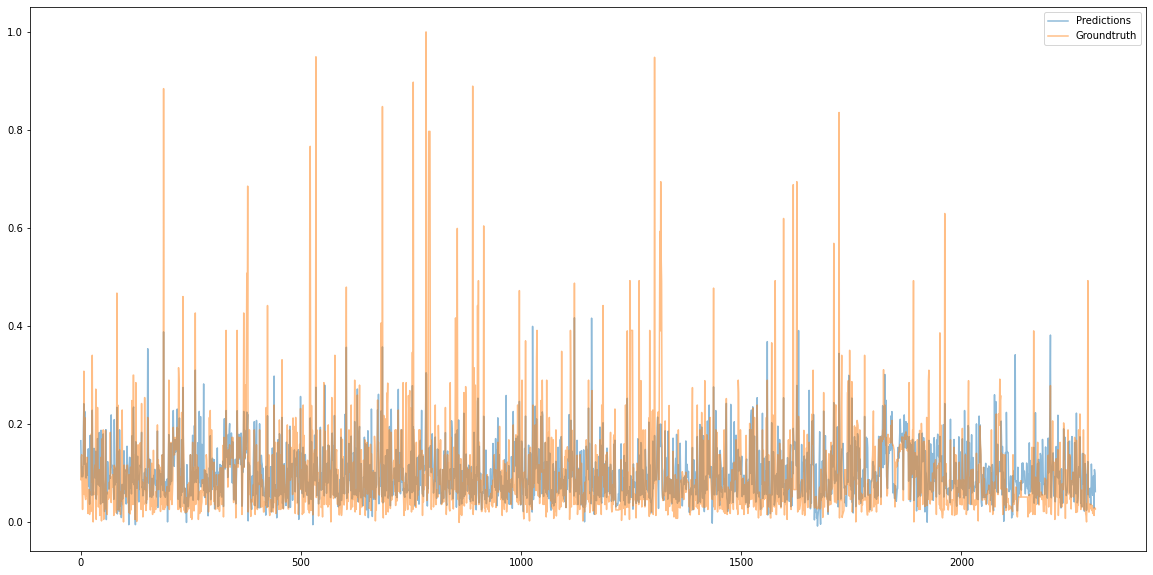

In [13]:
plt.figure(figsize=(20, 10))

y_pred = predict(model, tensor_data=X_data, gpu=0)

plt.plot(y_pred, label='Predictions', alpha=0.5)
plt.plot(y_data, label='Groundtruth', alpha=0.5)

plt.legend()
plt.show()

Le modèle sort des résultats fortement intéressant. Notre modèle est adapté et répond bien à la problématique de la prédiction de prix en fonction des données que nous avons sur la logement en location.

Cependant, le modèle a du mal à représenter les prix très élevées. Il lui arrive parfois de faire de gros écarts, mais de manière générale, la distribution semble bien respectée.

## ResNet

Essayons de reprendre le principe du ResNet (en oubliant les convolutions).

In [14]:
class ResNet(nn.Module):
    def __init__(self, in_features=32, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        
        # Bloc 1
        self.bloc1 = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(in_features=in_features, out_features=128)),
            ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(in_features=128, out_features=128)),
            ('relu2', nn.ReLU()),
            ('linear3', nn.Linear(in_features=128, out_features=32))
        ]))
        
        # Bloc 2
        self.bloc2 = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(in_features=in_features, out_features=128)),
            ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(in_features=128, out_features=128)),
            ('relu2', nn.ReLU()),
            ('linear3', nn.Linear(in_features=128, out_features=32))
        ]))
        
        # Bloc 3
        self.bloc3 = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(in_features=in_features, out_features=128)),
            ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(in_features=128, out_features=128)),
            ('relu2', nn.ReLU()),
            ('linear3', nn.Linear(in_features=128, out_features=32))
        ]))
        
        # Regression
        self.regress = nn.Linear(in_features=32, out_features=1)
    
    def forward(self, x):
        x_prev = x
        x = self.bloc1(x)
        x_prev = x_prev + x
        x = self.bloc2(x)
        x_prev = x_prev + x
        x = self.bloc3(x)
        x_prev = x_prev + x
        y = self.regress(x)
        return y

In [15]:
# test pour s’assurer que le flux de données passe bien au travers du réseau
model_resnet = ResNet()
X_data = torch.FloatTensor(X_data)
with torch.no_grad():
    res = model_resnet(X_data[:10])
print(res.shape)

torch.Size([10, 1])


#### Overfitting

In [16]:
model_resnet = ResNet()

loss = nn.MSELoss()

lr = 0.01
optimizer = optim.SGD(model_resnet.parameters(), lr=lr)

hist = train(model_resnet, optimizer, loss, train_loader=test_loader, epochs=300, gpu=0)

Epoch : 1 - Train Loss : 9.53e-03
Epoch : 2 - Train Loss : 8.42e-03
Epoch : 3 - Train Loss : 8.02e-03
Epoch : 4 - Train Loss : 7.87e-03
Epoch : 5 - Train Loss : 7.82e-03
Epoch : 6 - Train Loss : 7.80e-03
Epoch : 7 - Train Loss : 7.79e-03
Epoch : 8 - Train Loss : 7.79e-03
Epoch : 9 - Train Loss : 7.78e-03
Epoch : 10 - Train Loss : 7.78e-03
Epoch : 11 - Train Loss : 7.78e-03
Epoch : 12 - Train Loss : 7.78e-03
Epoch : 13 - Train Loss : 7.78e-03
Epoch : 14 - Train Loss : 7.78e-03
Epoch : 15 - Train Loss : 7.78e-03
Epoch : 16 - Train Loss : 7.78e-03
Epoch : 17 - Train Loss : 7.78e-03
Epoch : 18 - Train Loss : 7.78e-03
Epoch : 19 - Train Loss : 7.78e-03
Epoch : 20 - Train Loss : 7.78e-03
Epoch : 21 - Train Loss : 7.78e-03
Epoch : 22 - Train Loss : 7.78e-03
Epoch : 23 - Train Loss : 7.78e-03
Epoch : 24 - Train Loss : 7.78e-03
Epoch : 25 - Train Loss : 7.78e-03
Epoch : 26 - Train Loss : 7.78e-03
Epoch : 27 - Train Loss : 7.78e-03
Epoch : 28 - Train Loss : 7.78e-03
Epoch : 29 - Train Loss : 7.7

Epoch : 231 - Train Loss : 7.78e-03
Epoch : 232 - Train Loss : 7.78e-03
Epoch : 233 - Train Loss : 7.78e-03
Epoch : 234 - Train Loss : 7.78e-03
Epoch : 235 - Train Loss : 7.78e-03
Epoch : 236 - Train Loss : 7.78e-03
Epoch : 237 - Train Loss : 7.78e-03
Epoch : 238 - Train Loss : 7.78e-03
Epoch : 239 - Train Loss : 7.78e-03
Epoch : 240 - Train Loss : 7.78e-03
Epoch : 241 - Train Loss : 7.78e-03
Epoch : 242 - Train Loss : 7.78e-03
Epoch : 243 - Train Loss : 7.78e-03
Epoch : 244 - Train Loss : 7.78e-03
Epoch : 245 - Train Loss : 7.78e-03
Epoch : 246 - Train Loss : 7.78e-03
Epoch : 247 - Train Loss : 7.78e-03
Epoch : 248 - Train Loss : 7.78e-03
Epoch : 249 - Train Loss : 7.78e-03
Epoch : 250 - Train Loss : 7.78e-03
Epoch : 251 - Train Loss : 7.78e-03
Epoch : 252 - Train Loss : 7.78e-03
Epoch : 253 - Train Loss : 7.78e-03
Epoch : 254 - Train Loss : 7.78e-03
Epoch : 255 - Train Loss : 7.78e-03
Epoch : 256 - Train Loss : 7.78e-03
Epoch : 257 - Train Loss : 7.78e-03
Epoch : 258 - Train Loss : 7

#### Petite visualisation de l’entrainement

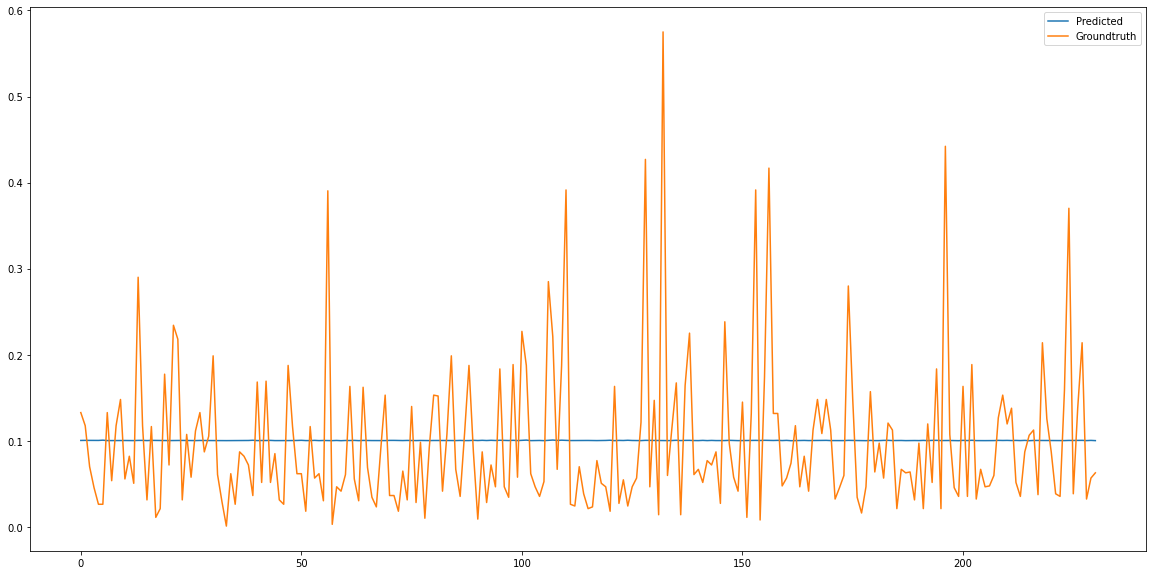

In [17]:
y_pred = predict(model_resnet, tensor_data=X_test, gpu=0)

plt.figure(figsize=(20, 10))
plt.plot(y_pred, label='Predicted')
plt.plot(y_test, label='Groundtruth')
plt.legend()
plt.show()

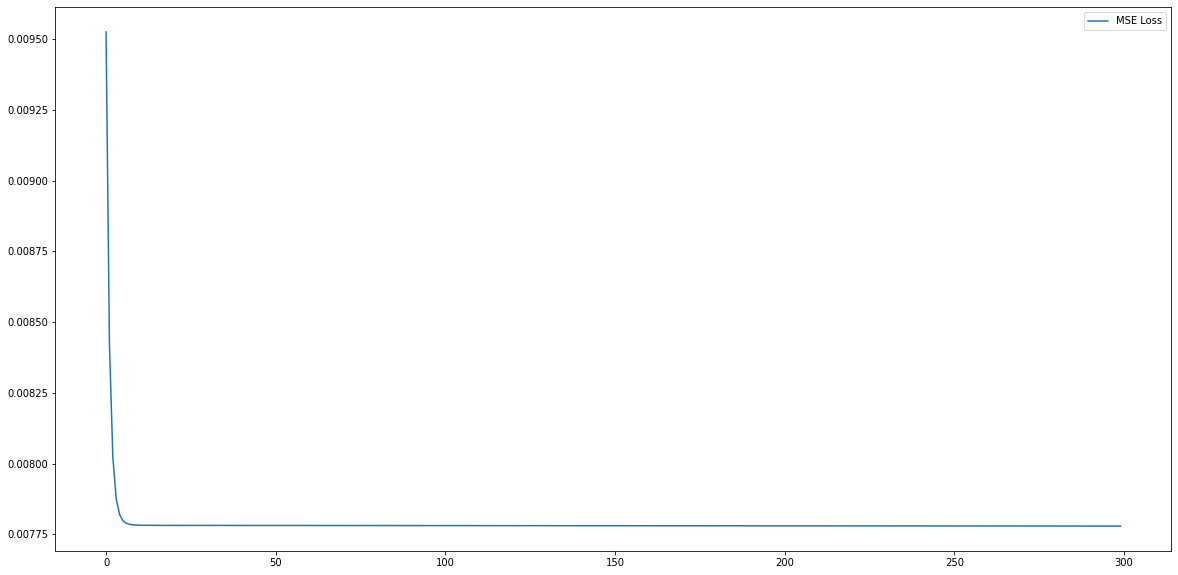

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(hist, label='MSE Loss')
plt.legend()
plt.show()

Le modèle overfit bien, comme dans le cas précédent, on est assuré d'avoir un modèle adapté à nos données.

#### Entrainement

In [19]:
model_resnet = ResNet()

loss = nn.MSELoss()

lr = 0.1
optimizer = optim.SGD(model_resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

hist = train(model_resnet, optimizer, loss, train_loader=train_loader, valid_loader=valid_loader, epochs=100, scheduler=scheduler, gpu=0)

Epoch : 1 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 2 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 3 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 4 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 5 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 6 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 7 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 8 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 9 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 10 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 11 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 12 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 13 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 14 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 15 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 16 - Train Loss : 1.11e-02 - - Valid Loss : 1.43e-02
Epoch : 17 - Train Loss : 1.11e-0

In [20]:
hist_test = test(model_resnet, loss, test_loader=test_loader, gpu=0)

Test batch : 15 / 15

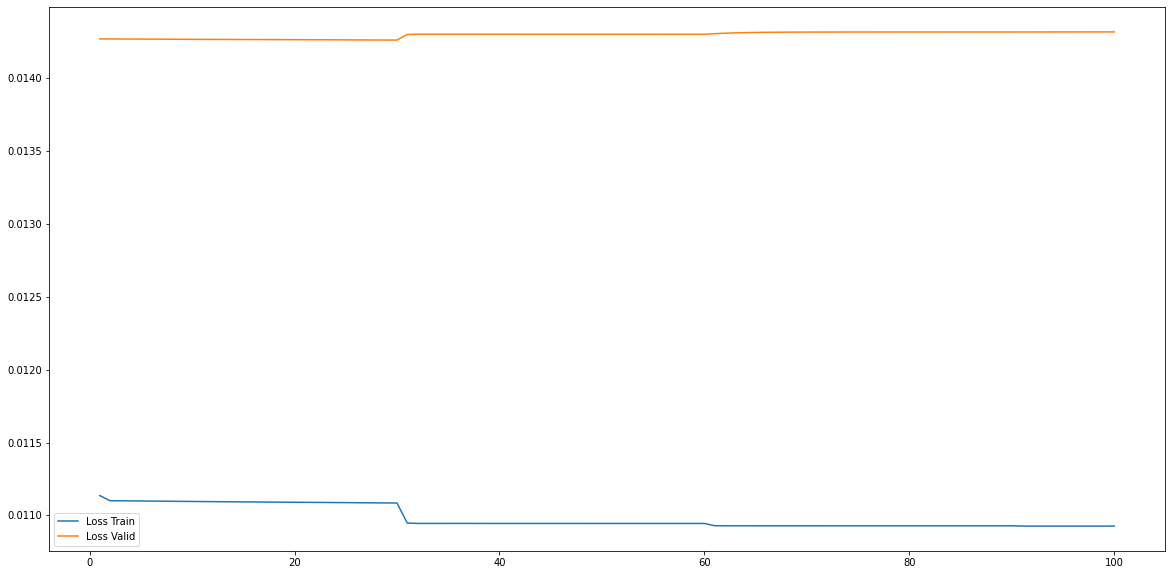

In [21]:
plt.figure(figsize=(20, 10))

x = np.arange(1, 101, 1)

plt.plot(x, hist[0], label='Loss Train')
plt.plot(x, hist[1], label='Loss Valid')

plt.legend()
plt.show()

Un phénomène innatendu, le modèle aurait de meilleurs résultats en validation qu’en entrainement.

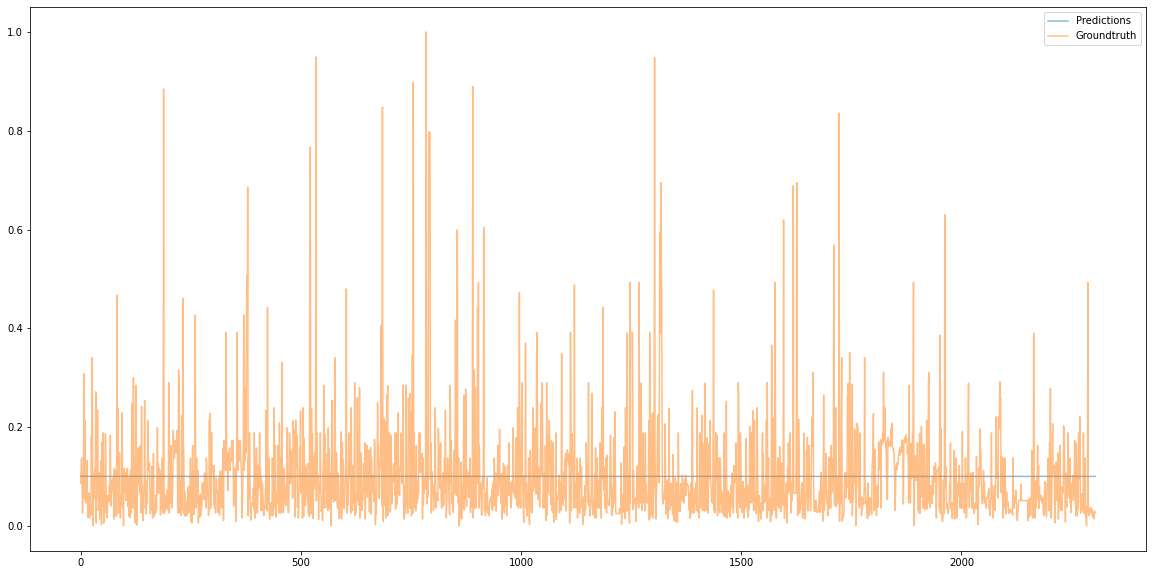

In [22]:
plt.figure(figsize=(20, 10))

y_pred = predict(model_resnet, tensor_data=X_data, gpu=0)

plt.plot(y_pred, label='Predictions', alpha=0.5)
plt.plot(y_data, label='Groundtruth', alpha=0.5)

plt.legend()
plt.show()

Le ResNet n'est pas bon car il a juste appris à moyenner le jeu d'entrainement, ce qui explique cette ligne droite de prédictions.

Le fait de réinjecter l'état précédent, afin de mieux faire circuler le gradient, n'apporte pas de meilleurs résultats.